<a href="https://colab.research.google.com/github/Sylou2022/NLP-LSTM/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install kaggle

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [41]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense
import numpy
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.layers import Attention
from keras.models import Model

# Télécharger les ressources nécessaires pour la lemmatisation
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Chargement du dataset

In [42]:
dataset = pd.read_csv("/content/IMDB Dataset.csv")
dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


<Axes: ylabel='count'>

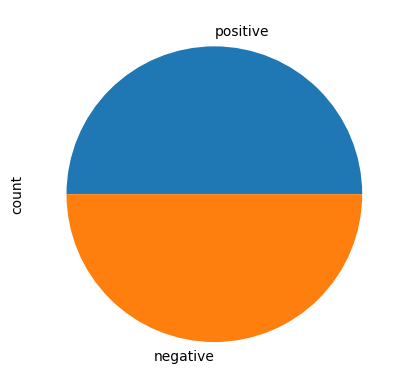

In [43]:
dataset['sentiment'].value_counts().plot(kind='pie')

# PRETRAITEMENT DE TEXTE

In [44]:
for col in dataset.columns:
    dataset['review'] = dataset['review'].apply(lambda x: BeautifulSoup(str(x), 'html.parser').get_text())

<ipython-input-44-f7af1ad26c38>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  dataset['review'] = dataset['review'].apply(lambda x: BeautifulSoup(str(x), 'html.parser').get_text())
<ipython-input-44-f7af1ad26c38>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  dataset['review'] = dataset['review'].apply(lambda x: BeautifulSoup(str(x), 'html.parser').get_text())


In [45]:
dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [46]:
dataset.columns

Index(['review', 'sentiment'], dtype='object')

In [47]:
stop_words = set(stopwords.words('english'))

# Spécifier la colonne à nettoyer
colonne_a_nettoyer = 'review'

# Fonction pour supprimer les stop words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Appliquer la fonction à la colonne spécifiée
dataset[colonne_a_nettoyer] = dataset[colonne_a_nettoyer].apply(remove_stopwords)

In [48]:
dataset

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,positive
1,wonderful little production. filming technique...,positive
2,thought wonderful way spend time hot summer we...,positive
3,Basically there's family little boy (Jake) thi...,negative
4,"Petter Mattei's ""Love Time Money"" visually stu...",positive
...,...,...
49995,thought movie right good job. creative origina...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,Catholic taught parochial elementary schools n...,negative
49998,I'm going disagree previous comment side Malti...,negative


Nettoyer la ponctuation

In [50]:
# Regex
def nettoyer_texte(text):
    # Convertir en minuscules, enlever la ponctuation et les apostrophes
    text = text.str.replace(r"['" + string.punctuation + r"]+", " ", regex=True)
    text = text.str.lower()
    text = text.str.replace(r"\s+", " ", regex=True)

    return text

dataset["review"] = nettoyer_texte(dataset['review'])


In [51]:
dataset

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there s family little boy jake think...,negative
4,petter mattei s love time money visually stunn...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,i m going disagree previous comment side malti...,negative


# Lemmatisation
### Réduire les mots à leur forme de base ou canonique pour normaliser les données textuelles.

### Parcourir chaque mots

In [52]:
# Initialisation de: wordnet lemmatizer
wnl = WordNetLemmatizer()

# lemmatiser chaque mots
dataset['review_lemmatized'] = dataset['review'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos="v") for word in x.split()]))

In [53]:
dataset['review_lemmatized'][0]

'one reviewers mention watch 1 oz episode hook right exactly happen me the first thing strike oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pull punch regard drug sex violence hardcore classic use word it call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cells glass front face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish more so scuffle death star dodgy deal shady agreements never far away i would say main appeal show due fact go show dare forget pretty picture paint mainstream audiences forget charm forget romance oz mess around first episode ever saw strike nasty surreal say ready it watch more develop taste oz get accustom high level graphic violence violence injustice crook guard who ll sell nickel inmates who ll kill order get away it well mannered middle class inmates turn prison bitch due lack street sk

# Tokenisation et Padding
### Tokenisez les textes en utilisant nltk, spaCy ou keras.
### Utilisez pad_sequences de Keras pour que toutes les séquences aient la même longueur.


In [54]:
# Tokenisation des textes lemmatisés
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review_lemmatized'])
sequences = tokenizer.texts_to_sequences(dataset['review_lemmatized'])


In [55]:
max_length = [len(seq) for seq in sequences]
my_words = pd.Series(max_length)
my_words.describe()

count    50000.000000
mean       129.520120
std         97.678253
min          3.000000
25%         69.000000
50%         96.000000
75%        158.000000
max       1492.000000
dtype: float64

In [56]:
len(my_words)

50000

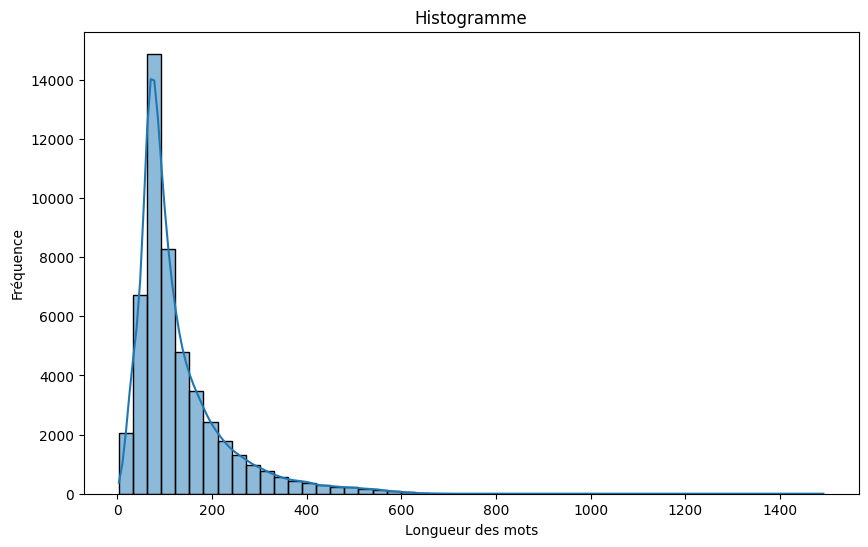

In [57]:
import seaborn as sns

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
sns.histplot(my_words, bins=50, kde=True)
plt.title('Histogramme')
plt.xlabel('Longueur des mots')
plt.ylabel('Fréquence')
plt.show()

In [58]:
tokenizer.word_index

{'film': 1,
 's': 2,
 'movie': 3,
 'one': 4,
 'make': 5,
 'like': 6,
 'see': 7,
 'get': 8,
 'i': 9,
 'time': 10,
 'good': 11,
 'it': 12,
 'character': 13,
 'watch': 14,
 'go': 15,
 'the': 16,
 'even': 17,
 'would': 18,
 'think': 19,
 'story': 20,
 'really': 21,
 'show': 22,
 'well': 23,
 'look': 24,
 'much': 25,
 'say': 26,
 'know': 27,
 'end': 28,
 'bad': 29,
 'people': 30,
 'great': 31,
 'also': 32,
 'first': 33,
 'act': 34,
 'take': 35,
 'give': 36,
 'love': 37,
 'play': 38,
 'come': 39,
 'find': 40,
 'way': 41,
 'could': 42,
 'movies': 43,
 'be': 44,
 'seem': 45,
 'work': 46,
 'plot': 47,
 'that': 48,
 'two': 49,
 'many': 50,
 'want': 51,
 'never': 52,
 'life': 53,
 'best': 54,
 'try': 55,
 'little': 56,
 'ever': 57,
 'man': 58,
 'this': 59,
 't': 60,
 'better': 61,
 'do': 62,
 'there': 63,
 'scene': 64,
 'still': 65,
 'and': 66,
 'scenes': 67,
 'feel': 68,
 'part': 69,
 'something': 70,
 'use': 71,
 'back': 72,
 'm': 73,
 'lot': 74,
 'interest': 75,
 'real': 76,
 'guy': 77,
 'thin

In [59]:
max_len = 500
X = pad_sequences(sequences, maxlen=max_len)

In [60]:
compter_mots = tokenizer.word_counts

compter_mots_data = pd.DataFrame(list(compter_mots.items()), columns=['word', 'count'])
compter_mots_data = compter_mots_data.sort_values(by='count', ascending=False)

# Gareder les mots ==> reviennent + de 10 fois
filtre_compter_mots_data = compter_mots_data[compter_mots_data['count'] > 10]

Max_words = len(filtre_compter_mots_data)
print(Max_words)

22181


# Encodage des Labels
## Utilisez LabelEncoder de sklearn pour transformer les labels catégoriels en valeurs numériques.


In [61]:
# Encoder les labels catégoriels
le = LabelEncoder()
dataset['label_encoded'] = le.fit_transform(dataset['sentiment'])

In [62]:
y = dataset['label_encoded']
y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: label_encoded, Length: 50000, dtype: int64

# Séparation des Données
## Divisez les données en ensembles d'entraînement et de test.


In [63]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [64]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

# Modèle LSTM

In [65]:
lstm_model = Sequential([
    Embedding(input_dim=84102, output_dim=128, input_length=500),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [66]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 128)          10765056  
                                                                 
 lstm_4 (LSTM)               (None, 500, 128)          131584    
                                                                 
 dropout_4 (Dropout)         (None, 500, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10946113 (41.76 MB)
Trainable params: 10

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [68]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entraînement du modèle
History = lstm_model.fit(X_train, y_train, epochs=50, batch_size = 32, validation_split = 0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1000/1000 [==============================] - 1470s 1s/step - loss: 0.4092 - accuracy: 0.8205 - val_loss: 0.3334 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - 1462s 1s/step - loss: 0.2492 - accuracy: 0.9071 - val_loss: 0.3115 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 3/50
 537/1000 [===============>..............] - ETA: 10:14 - loss: 0.1361 - accuracy: 0.9523

In [ ]:
lstm_model.save('lstm_model.h5')

# Modèle LSTM avec Attention :
Implémentez un modèle LSTM avec un mécanisme d'attention. Utilisez une couche Attention pour pondérer les sorties des LSTM.


In [ ]:
input_layer = Input(shape=(500,))
embedding_layer = Embedding(input_dim=84102, output_dim=128)(input_layer)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
output_layer = Dense(1, activation='sigmoid')(attention_layer)
flatened_output_layer = tf.reduce_min(output_layer, axis=1)

model_lstm_attention = Model(inputs=input_layer, outputs=flatened_output_layer)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

# model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)
model_lstm_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrainement du modele Attention
model_lstm_attention.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])


In [ ]:
model_lstm_attention.save('model_lstm_attention.h5')

In [41]:
model_lstm_attention.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 100, 128)             1076505   ['input_4[0][0]']             
                                                          6                                       
                                                                                                  
 lstm_5 (LSTM)               (None, 100, 128)             131584    ['embedding_4[0][0]']         
                                                                                                  
 attention_3 (Attention)     (None, 100, 128)             0         ['lstm_5[0][0]',        

#Modèle Transformer :
Implémentez un modèle Transformer en utilisant la classe Transformer de Hugging Face ou une autre bibliothèque similaire.


In [42]:
from transformers import TFBertForSequenceClassification, BertTokenizer

# Chargement du tokenizer et du modèle pré-entraîné
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_transformer = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Exemple d'utilisation du modèle
inputs = tokenizer("Hello, how are you?", return_tensors="tf")
outputs = model_transformer(inputs)

# Affichage des prédictions
print(outputs)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.23490873, -0.13016209]], dtype=float32)>, hidden_states=None, attentions=None)


# FAIRE LA COURBE ROC, ACCURACY

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Adapter les séquences d'entrée à la longueur attendue (500)
X_test_padded = pad_sequences(X_test, maxlen=500)

# Faire des prédictions sur l'ensemble de test adapté
y_pred_prob = model_lstm_attention.predict(X_test_padded)

# Vérifier et aplatir y_pred_prob si nécessaire
if len(y_pred_prob.shape) > 2:
    y_pred_prob = y_pred_prob.reshape((y_pred_prob.shape[0], y_pred_prob.shape[1]))

# Calculer les scores ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

In [ ]:
# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {auc:.2f}')